In [64]:
import ezdxf
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from datetime import date



In [65]:
# Init dxf document
def init_dxf():
    doc = ezdxf.new('R2000')
    msp = doc.modelspace()
    doc.header['$INSUNITS'] = 13  # 13 is the code for micrometers in DXF
    doc.header['$MEASUREMENT'] = 1  # 1 for metric measurement system
    doc.header['$LUNITS'] = 4  # 4 for decimal units
    doc.header['$LUPREC'] = 6  # 6 decimal places for units
    return doc, msp

In [66]:
# Create rectangles
def create_rectangles(msp, ipattern, bondpad_width, bondpad_start, number_of_rectangles, g, w, length, turning):
    xoffset = (bondpad_width+length*3)*(1/2+(ipattern%2))
    xint1 = xoffset 
    yint1 = -(g+w)*number_of_rectangles
    x_position = xint1
    y_position = yint1
    for i in range(number_of_rectangles):
        # Create a rectangle for each width
        # Points for rectangle: bottom-left -> bottom-right -> top-right -> top-left
        points = [
            (x_position, y_position),
            (x_position+length, y_position),
            (x_position+length, y_position + w),
            (x_position, y_position + w),
            (x_position, y_position + 2*w + 2*g)
        ]
        # Draw rectangle as a closed polyline
        msp.add_lwpolyline(points, close=True)
        # Update y position for next rectangle with some spacing
        y_position += 2*w + 2*g
    points = [
        (x_position, y_position),
        (x_position, bondpad_start),
        (x_position - turning, bondpad_start),
        (xint1 - turning, -bondpad_start),
        (xint1, -bondpad_start),
        (xint1, yint1)
    ]
    # Draw rectangle as a closed polyline
    msp.add_lwpolyline(points, close=True)
    # Now create the second side
    x_position += length + turning
    y_position = y_position - g
    xint2 = x_position
    yint2 = y_position
    for i in range(number_of_rectangles):
        # Create a rectangle for each width
        # Points for rectangle: bottom-left -> bottom-right -> top-right -> top-left
        points = [
            (x_position, y_position),
            (x_position-length, y_position),
            (x_position-length, y_position-w),
            (x_position, y_position-w),
            (x_position, y_position - 2*w - 2*g)
        ]
        # Draw rectangle as a closed polyline
        msp.add_lwpolyline(points, close=True)
        # Update y position for next rectangle with some spacing
        y_position -= (2*w+2*g)
    points = [
        (x_position, y_position),
        (x_position, -bondpad_start),
        (x_position + turning, -bondpad_start),
        (xint2 + turning, bondpad_start),
        (xint2, bondpad_start),
        (xint2, yint2)
    ]
    msp.add_lwpolyline(points, close=True)
    return xint1, xint2, yint1, yint2

In [67]:
# Create the bondpads
def create_bondpads(msp, xint1, xint2, bondpad_start, bondpad_length, bondpad_width, length, turning):
    # Bondpads
    points = [
        (xint1, -bondpad_start),
        (xint1-bondpad_width/2, -bondpad_start - bondpad_length),
        (xint1-bondpad_width/2, -bondpad_start - 2*bondpad_length),
        (xint1 + bondpad_width/2 + length, -bondpad_start - 2*bondpad_length),
        (xint1 + bondpad_width/2 + length, -bondpad_start - bondpad_length),
        (xint1 + length + turning, -bondpad_start),
        (xint1 + length + turning + turning, -bondpad_start ),
        (xint1 + length + turning + turning + bondpad_width/2, -bondpad_start - bondpad_length),
        (xint1 + length + turning + turning + bondpad_width/2, -bondpad_start - 2*bondpad_length - turning),
        (xint1 - bondpad_width/2 - turning - turning, -bondpad_start - 2*bondpad_length - turning),
        (xint1 - bondpad_width/2 - turning - turning, -bondpad_start - bondpad_length),
        (xint1 - turning, -bondpad_start),
    ]
    msp.add_lwpolyline(points, close=True)
    points = [
        (xint2, bondpad_start),
        (xint2 + bondpad_width/2, bondpad_start + bondpad_length),
        (xint2 + bondpad_width/2, bondpad_start + 2*bondpad_length),
        (xint2 - bondpad_width/2 - length, bondpad_start + 2*bondpad_length),
        (xint2 - bondpad_width/2 - length, bondpad_start + bondpad_length),
        (xint2 - length - turning, bondpad_start),
        (xint2 - length - turning - turning, bondpad_start),
        (xint2 - length - turning - turning - bondpad_width/2, bondpad_start + bondpad_length),
        (xint2 - length - turning - turning - bondpad_width/2, bondpad_start + 2*bondpad_length + turning),
        (xint2 + bondpad_width/2 + turning + turning, bondpad_start + 2*bondpad_length + turning),
        (xint2 + bondpad_width/2 + turning + turning, bondpad_start + bondpad_length),
        (xint2 + turning, bondpad_start),
    ]
    msp.add_lwpolyline(points, close=True)

In [68]:
# Create fiducial circles
def create_fiducial_circles_small(msp, xint1, xint2, yint1, yint2, length, ipattern):
    # Create fiducial circles based on ipattern
    center_x = (xint1 + xint2) / 2 + length
    center_y = (yint1 + yint2) / 2
    radius = 1
    # Calculate number of rows needed (5 circles per row)
    rows = (ipattern + 1) // 5 if (ipattern + 1) > 5 else 1
    cols = min(5, ipattern + 1)    
    for i in range(ipattern + 1):
        # Calculate row and column position
        row = i // 5
        col = i % 5        
        # Offset circle position based on row and column
        circle_center_x = center_x + (col * 2 * radius) + col*0.2
        circle_center_y = center_y - (row * 2 * radius) - row*0.5        
        # Create circle as polyline with 36 points
        circle_points = [(circle_center_x + radius * math.cos(math.radians(angle)), 
        circle_center_y + radius * math.sin(math.radians(angle))) 
            for angle in range(0, 360, 10)]
        msp.add_lwpolyline(circle_points, close=True)

def create_fiducial_squares_large(msp, bondpad_width, turning, ipattern):
    ifile = int((ipattern+1) / 2)
    # Create large fiducial square at (bondpad_width, 0)
    square_size = 10
    half_size = square_size / 2
    center_x = bondpad_width
    center_y = 0
    for i in range(ifile):
        # Calculate row and column position
        row = i // 5
        col = i % 5   
        # Offset the square position based on the file index
        offset_x = col * (square_size + 10 * turning)
        offset_y = row * (square_size + 10 * turning)
        center_x_offset = center_x + offset_x
        center_y_offset = center_y + offset_y   
        # Create square points
        square_points_inner = [
            (center_x_offset - half_size, center_y_offset - half_size),
            (center_x_offset + half_size, center_y_offset - half_size),
            (center_x_offset + half_size, center_y_offset + half_size),
            (center_x_offset - half_size, center_y_offset + half_size),
            (center_x_offset - half_size, center_y_offset - half_size)
        ]
        msp.add_lwpolyline(square_points_inner, close=True)
        square_points_outter = [
            (center_x_offset - half_size - turning, center_y_offset - half_size - turning),
            (center_x_offset + half_size + turning, center_y_offset - half_size - turning),
            (center_x_offset + half_size + turning, center_y_offset + half_size + turning),
            (center_x_offset - half_size - turning, center_y_offset + half_size + turning),
            (center_x_offset - half_size - turning, center_y_offset - half_size - turning)
        ]
        msp.add_lwpolyline(square_points_outter, close=True)

In [ ]:
# Parameters
version = 20250711
length = 15
width = [0.1,0.15,0.2,0.3]
gap = [0.1,0.2,0.3,0.4,0.5]
number_of_rectangles = 15
turning = 0.8
bondpad_width = 250
bondpad_length = 100
field_size = 600
bondpad_start = 80
#width = [0.08, 0.1, 0.12, 0.15, 0.2, 0.4, 0.6, 1.0, 2.0, 4.0]
#gap = [0.05,0.1,0.2,0.5]

# Create directory with today's date
directory = f"lt_wb_{version}"
if not os.path.exists(directory):
    os.makedirs(directory)

In [70]:
# Main program
# Initialize pattern counter
doc, msp = init_dxf()
ipattern = 0
for g in gap:
    for w in width:
        # print(f"{ipattern},{g},{w}")

        # Create rectangles
        xint1, xint2, yint1, yint2 = create_rectangles(msp, ipattern, bondpad_width, bondpad_start, number_of_rectangles, g, w, length, turning)
        # Create bondpads
        create_bondpads(msp, xint1, xint2, bondpad_start, bondpad_length, bondpad_width, length, turning)
        # Create fiducial circles
        create_fiducial_circles_small(msp, xint1, xint2, yint1, yint2, length, ipattern)

        # Create new DXF document for each pair of patterns
        if ipattern % 2 == 1:
            # Create large fiducial square
            create_fiducial_squares_large(msp, bondpad_width, turning, ipattern)
            # Save the DXF file
            doc.saveas(f'{directory}/{int((ipattern+1)/2)}.dxf')
            # Reset the document for the next pattern
            doc, msp = init_dxf()
        ipattern += 1

(-15.0, 15.0)

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


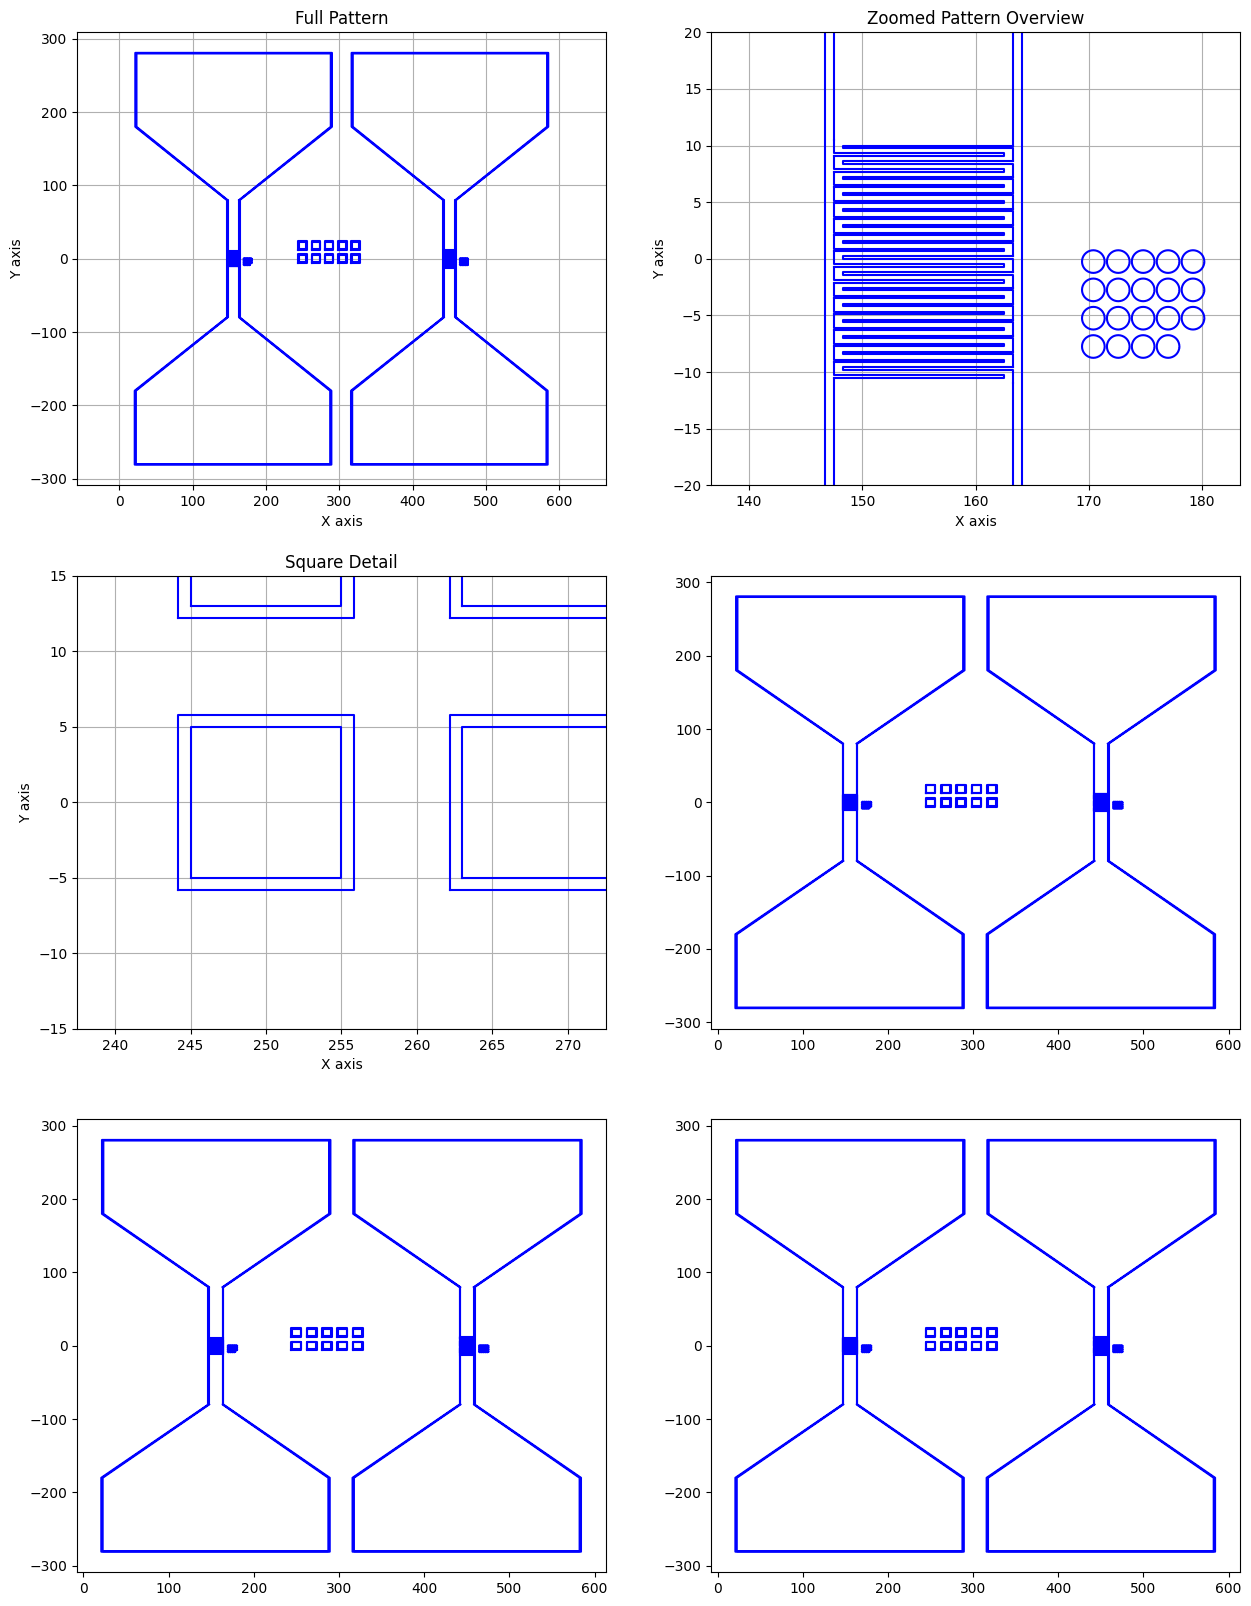

In [87]:
# Create a figure with six subplots (3x2 layout)
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15, 20))
# Open the DXF file
doc = ezdxf.readfile(f'{directory}/10.dxf')
msp = doc.modelspace()
# Main pattern plotting
for entity in msp:
    if entity.dxftype() == 'LWPOLYLINE':
        points = entity.get_points()
        x_coords = [p[0] for p in points]
        y_coords = [p[1] for p in points]
        ax1.plot(x_coords, y_coords, 'b-')
        ax2.plot(x_coords, y_coords, 'b-')
        ax3.plot(x_coords, y_coords, 'b-')
        ax4.plot(x_coords, y_coords, 'b-')
        ax5.plot(x_coords, y_coords, 'b-')
        ax6.plot(x_coords, y_coords, 'b-')

# Configure subplots
ax1.grid(True)
ax1.set_title('Full Pattern')
ax1.set_xlabel('X axis')
ax1.set_ylabel('Y axis')
ax1.axis('equal')

ax2.grid(True)
ax2.set_title('Zoomed Pattern Overview')
ax2.set_xlabel('X axis')
ax2.set_ylabel('Y axis')
ax2.axis('equal')
ax2.set_xlim(140,180)
ax2.set_ylim(-20, 20)

ax3.grid(True)
ax3.set_title('Square Detail')
ax3.set_xlabel('X axis')
ax3.set_ylabel('Y axis')
ax3.axis('equal')
ax3.set_xlim(240,270)
ax3.set_ylim(-15,15)

# ax4.grid(True)
# ax4.set_title('Bottom Connection Detail')
# ax4.set_xlabel('X axis')
# ax4.set_ylabel('Y axis')
# ax4.axis('equal')
# ax4.set_xlim([xint1-5, xint1+length+turning+5])
# ax4.set_ylim([-field_size/2, -field_size/2])

# ax5.grid(True)
# ax5.set_title('Bottom Bond Pad Detail')
# ax5.set_xlabel('X axis')
# ax5.set_ylabel('Y axis')
# ax5.axis('equal')
# ax5.set_xlim([xint1-bondpad_width-turning-turning-5, xint1+length+turning+turning+bondpad_width+5])
# ax5.set_ylim([-field_size/2-2*bondpad_length-turning-5, -field_size/2+5])

# ax6.grid(True)
# ax6.set_title('Top Bond Pad Detail')
# ax6.set_xlabel('X axis')
# ax6.set_ylabel('Y axis')
# ax6.axis('equal')
# ax6.set_xlim([xint2-length-turning-turning-bondpad_width-5, xint2+bondpad_width+turning+turning+5])
# ax6.set_ylim([field_size/2-5, field_size/2+2*bondpad_length+turning+5])

# plt.tight_layout()
# plt.show()
